In [1]:
%load_ext autoreload
%autoreload 2

import os
import zarr
import dask.array as da
import napari
import sys
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy.orm import Session

from ete3 import Tree

sys.path.append('../libraries')
import family_graph as fg
from cells_database import Base, CellDB, TrackDB

In [2]:
os.environ['NAPARI_PERFMON'] = '0'

In [3]:
labels_zarr_path = r'D:\kasia\tracking\E6_exp\code\tests\example_track_labels.zarr'
labels = da.from_zarr(labels_zarr_path)
labels.shape

(241, 8396, 8401)

In [4]:
# get an example small set of labels
# labels_small = labels[:10, 4000:4500, 4000:4500].compute()
# labels_small.shape

In [5]:
# display the labels
viewer = napari.Viewer()
labels_layer = viewer.add_labels(labels,name='Labels')
fg.viewer = viewer

In [6]:
# get access to the database
new_db_path = r'D:\kasia\tracking\E6_exp\code\gardener_20_dev\cells_database_2tables - Copy.db'
engine = create_engine(f'sqlite:///{new_db_path}')

# send engine to the library
fg.engine = engine

In [7]:
# create a plot widget
t_max = viewer.dims.range[0][1]
plot_widget = fg.build_lineage_widget(t_max)
fg.plot_widget = plot_widget


# add lineage graph
viewer.window.add_dock_widget(plot_widget,area='bottom',name='family')

In [8]:
# connect lineage graph update
labels_layer.events.selected_label.connect(fg.update_lineage_display)

<function family_graph.update_lineage_display(event)>

In [10]:
import track_module as tm 
from napari import Viewer
from magicgui import magicgui

In [26]:
descendants =tm.get_descendants(engine,22003)
descendants

[(22003, -1, 22003, 0, 6),
 (22004, 22003, 22003, 7, 131),
 (22005, 22003, 22003, 7, 197)]

In [11]:
@magicgui()
def cut_track(viewer: Viewer):

    ####################################################################################################
    # orient yourself - figure what is asked for 

    # get the position in time
    current_frame = viewer.dims.current_step[0]

    # get my label
    active_label = int(viewer.layers['Labels'].selected_label)

    # find new track number
    new_track = tm.newTrack_number(engine)

    ####################################################################################################
    # perform database operations

    # get descendants
    descendants =tm.get_descendants(engine,active_label)

    # Database operations
    # cut cellsDB
    track_bbox = tm.cut_cellsDB(engine,descendants,active_label,current_frame,new_track)

    # cut trackDB
    tm.modify_trackDB(engine,descendants,active_label,current_frame,new_track)

    ####################################################################################################
    # modify labels
    if track_bbox is not None:

        sel = labels[current_frame:track_bbox[0],track_bbox[1]:track_bbox[2],track_bbox[3]:track_bbox[4]]
        sel[sel == active_label] = new_track
        labels[current_frame:track_bbox[0],track_bbox[1]:track_bbox[2],track_bbox[3]:track_bbox[4]] = sel

        viewer.layers['Labels'].data = labels

    ####################################################################################################
    # update lineage graph
    viewer.layers['Labels'].selected_label = new_track

    ####################################################################################################
    # change viewer status
    viewer.status = f'Track {active_label} has been cut.'

In [12]:
from qtpy.QtGui import QIcon

In [13]:
path_to_some_icon = r'D:\kasia\tracking\E6_exp\code\tracks_interactions\icons\icons8-scissors-50.png'

icon = QIcon(path_to_some_icon)
cut_track.call_button.native.setIcon(icon)
cut_track.call_button.native.setText(None)

viewer.window.add_dock_widget(cut_track,area='right',name='cut_track')
cut_track.call_button.native.resize(40,40)

In [14]:
label_color = labels_layer.get_color(42365)

In [15]:
label_color

array([0.56607443, 0.41737616, 0.35140616, 1.        ], dtype=float32)

C:\Users\kmk280\AppData\Local\Temp\ipykernel_11512\2232659263.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([1],[1],c=label_color,s = 100)


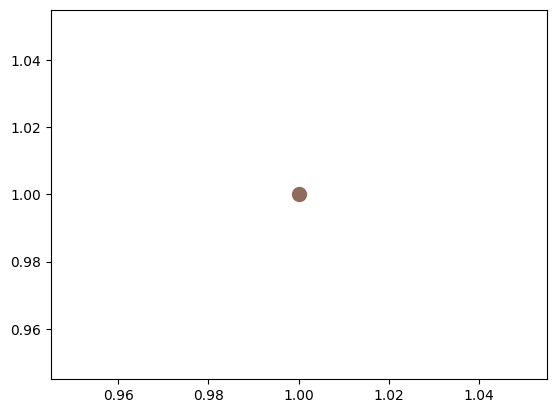

In [19]:
import matplotlib.pyplot as plt

plt.scatter([1],[1],c=label_color,s = 100)

In [23]:
viewer1 = napari.Viewer()
data = np.zeros((2,2)).astype('uint16')
data[0,0] = 42365
viewer1.add_labels(data)

<Labels layer 'data' at 0x2771f228e50>

In [16]:
print(active_label)
print(new_track)
print(current_frame) 

44965
75023
120


In [22]:
napari.__version__

'0.4.18'

In [17]:
# get descendants
descendants = get_descendants(engine,active_label)

# Database operations
# cut cellsDB
track_bbox = cut_cellsDB(engine,descendants,active_label,current_frame,new_track)

# cut trackDB
modify_trackDB(engine,descendants,active_label,current_frame,new_track)

# modify labels if needed
if track_bbox is not None:

    sel = labels[current_frame:track_bbox[0],track_bbox[1]:track_bbox[2],track_bbox[3]:track_bbox[4]]
    sel[sel == active_label] = new_track
    labels[current_frame:track_bbox[0],track_bbox[1]:track_bbox[2],track_bbox[3]:track_bbox[4]] = sel

    viewer.layers['Labels'].data = labels

# update lineage graph
viewer.layers['Labels'].selected_label = new_track

In [45]:
print(new_track)
print(track_bbox)

75019
(47, 3941, 4010, 4153, 4209)


In [18]:
with Session(engine) as session:

    query = session.query(TrackDB).filter(TrackDB.root == new_track).all()

query


[Track 44966 from 139 to 178,
 Track 44967 from 179 to 240,
 Track 44968 from 179 to 196,
 Track 44969 from 139 to 240,
 Track 75023 from 120 to 138]

In [53]:
with Session(engine) as session:

    query = session.query(CellDB).filter\
        (and_(CellDB.track_id == active_label, CellDB.t >= current_frame))\
    .order_by(CellDB.t).all()

In [54]:
query

[17004006 from frame 16 with track_id 11430 at (3959,4190),
 18004011 from frame 17 with track_id 11430 at (3958,4188),
 19004042 from frame 18 with track_id 11430 at (3960,4186),
 20004162 from frame 19 with track_id 11430 at (3961,4186),
 21004244 from frame 20 with track_id 11430 at (3960,4184),
 22004265 from frame 21 with track_id 11430 at (3959,4183),
 23004320 from frame 22 with track_id 11430 at (3958,4182),
 24004298 from frame 23 with track_id 11430 at (3957,4180),
 25004413 from frame 24 with track_id 11430 at (3959,4186),
 26004425 from frame 25 with track_id 11430 at (3954,4175),
 27004476 from frame 26 with track_id 11430 at (3955,4174),
 28004499 from frame 27 with track_id 11430 at (3959,4180),
 29004646 from frame 28 with track_id 11430 at (3960,4178),
 30004605 from frame 29 with track_id 11430 at (3962,4174),
 31004688 from frame 30 with track_id 11430 at (3963,4174),
 32004702 from frame 31 with track_id 11430 at (3965,4172),
 33004717 from frame 32 with track_id 11

In [151]:
print(row_start)
print(row_stop)
print(column_start)
print(column_stop)
print(current_frame)
print(t_stop)

0
0
0
0
19
0


In [142]:
viewer.layers['Labels'].data = labels

In [110]:
with Session(engine) as session:
    
    query = session.query(CellDB).filter((CellDB.track_id == newTrack))
    df = pd.read_sql(query.statement, engine)

In [111]:
df.head()

,track_id,t,id,parent_id,row,col,bbox_0,bbox_1,bbox_2,bbox_3,mask
0,75019,71,72009349,-1,5578,4428,5561,4413,5597,4445,"[[False, False, False, False, False, False, Fa..."
1,75019,72,73009365,72009349,5570,4425,5553,4410,5588,4441,"[[False, False, False, False, False, False, Fa..."
2,75019,73,74009387,73009365,5569,4423,5551,4409,5589,4439,"[[False, False, False, False, False, False, Fa..."
3,75019,74,75009333,74009387,5563,4421,5545,4408,5583,4437,"[[False, False, False, False, False, False, Fa..."
4,75019,75,76009314,75009333,5558,4417,5540,4401,5576,4434,"[[False, False, False, False, False, False, Fa..."


### Test

In [9]:
my_root = 1

plot_view = plot_widget.getItem(0,0)
plot_view.clear()

# buid the tree
tree = fg.build_Newick_tree(engine, my_root)

In [10]:
# update the widget with the tree
plot_view = fg.render_tree_view(plot_view,tree,viewer)